In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import random
from skimage import data
from skimage.transform import pyramid_gaussian

      
drive.mount('/content/gdrive')
gdrive = "/content/gdrive/My Drive/ProjectHumanDetection/"

run_path = 'googleData/cropped_run/processed'  # 120 images
walk_path = 'googleData/cropped_walk/processed'  # 160 images
stand_path = 'googleData/cropped_run/processed'  # 108 images



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
clas = {0: 'stand', 1: 'walk', 2: 'run'}
# separate test and train images 3-7
test_images = []
test_labels = []
train_images = []
train_labels = []

image_path = [stand_path, walk_path, run_path]

for i in range(len(image_path)):
  files = listdir(gdrive + image_path[i])
  random.shuffle(files)
  sep = int(0.3 * len(files))
  for png in files[:sep]:
    img = cv2.imread(gdrive + image_path[i] + '/' + png)
    test_images.append(img)
  test_labels += [i] * sep
  for png in files[sep:]:
    img = cv2.imread(gdrive + image_path[i] + '/' + png)
    train_images.append(img)
  train_labels += [i] * (len(files) - sep) 

# load into array
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

In [0]:
def get_hog_descriptors(images):
  """ gets the hog descriptors for each of the images, and returns a
  ndarray containing all the descriptors
  """
  img_count = images.shape[0]
  hog = cv2.HOGDescriptor()
  results = np.zeros((img_count, 3780, 1))
  for i in range(img_count):
    results[i, :, :] = hog.compute(images[i, :, :].astype(np.uint8))
  return results

train_hog = get_hog_descriptors(train_images) 
test_hog = get_hog_descriptors(test_images)

Train on 280 samples, validate on 120 samples
Epoch 1/6
280/280 [==============================] - 1s 3ms/step - loss: 1.3101 - acc: 0.3750 - val_loss: 1.1131 - val_acc: 0.3083
Epoch 2/6
280/280 [==============================] - 0s 207us/step - loss: 1.1606 - acc: 0.2964 - val_loss: 1.2397 - val_acc: 0.4167
Epoch 3/6
280/280 [==============================] - 0s 181us/step - loss: 1.1344 - acc: 0.4143 - val_loss: 1.0682 - val_acc: 0.4583
Epoch 4/6
280/280 [==============================] - 0s 184us/step - loss: 1.0584 - acc: 0.4357 - val_loss: 1.0603 - val_acc: 0.4417
Epoch 5/6
280/280 [==============================] - 0s 195us/step - loss: 0.9227 - acc: 0.5679 - val_loss: 1.1205 - val_acc: 0.5000
Epoch 6/6
280/280 [==============================] - 0s 185us/step - loss: 1.0154 - acc: 0.5643 - val_loss: 1.0707 - val_acc: 0.4833
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


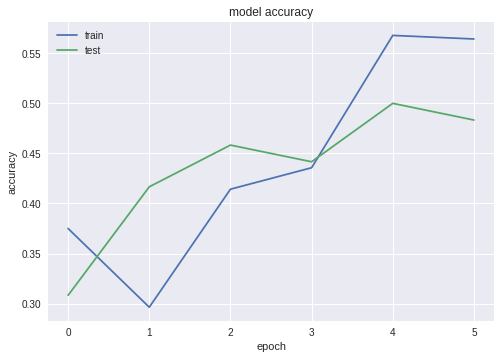

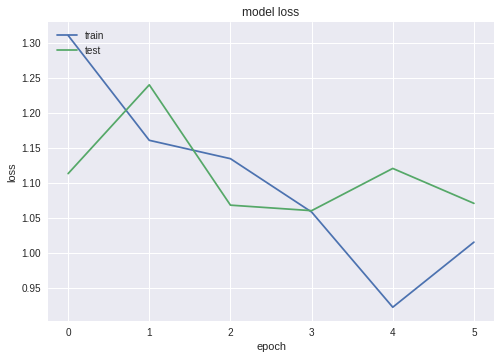

In [4]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3780, 1)),
    keras.layers.Dense(256, activation=tf.nn.sigmoid),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_hog, train_labels,
                    validation_data=(test_hog, test_labels)
                    , batch_size=128, epochs= 6)

# plot code sourced from: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
# save the final model !
model.save(gdrive + 'poseDectectionModel')